In [3]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    # df_2019_list.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv'))) (제외)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        print('dd', dataset[i].dropna().sum())
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled


In [4]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]

dd obs_x1_lon          9365.471710
obs_x1_lat          2625.377980
model_x2_lon        9397.252120
model_x2_lat        2619.735677
wind_y              -223.128525
wind_x              -169.814762
water_velocity_y       3.104966
water_velocity_x      -1.261281
hour                 828.000000
wind                 471.798834
water                  6.922849
diff_lon              -0.860890
diff_lat              -0.137430
diff                   1.260368
dtype: float64
dd obs_x1_lon          9385.393560
obs_x1_lat          2611.544350
model_x2_lon        9345.924320
model_x2_lat        2591.911581
wind_y                 7.113362
wind_x                 4.561414
water_velocity_y      -4.096806
water_velocity_x      -6.013417
hour                 828.000000
wind                 192.566420
water                 14.714293
diff_lon               0.689340
diff_lat               0.263490
diff                   0.975133
dtype: float64
dd obs_x1_lon          9402.538710
obs_x1_lat          2670.197370
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:115: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning

dd obs_x1_lon          9052.533000
obs_x1_lat          2629.592330
model_x2_lon        9047.017519
model_x2_lat        2639.147236
wind_y              -213.410165
wind_x               634.678055
water_velocity_y      -1.402117
water_velocity_x       2.825553
hour                 828.000000
wind                 748.456652
water                 40.443842
diff_lon               0.467900
diff_lat              -0.304590
diff                   1.569821
dtype: float64
dd obs_x1_lon          9071.168510
obs_x1_lat          2601.830450
model_x2_lon        9079.526264
model_x2_lat        2597.238981
wind_y               138.227941
wind_x              -204.628375
water_velocity_y       6.449386
water_velocity_x       0.258247
hour                 828.000000
wind                 442.663213
water                 28.358990
diff_lon              -0.242650
diff_lat               0.194170
diff                   1.394438
dtype: float64
dd obs_x1_lon          9074.055000
obs_x1_lat          2576.186010
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:115: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning

dd obs_x1_lon          8994.496320
obs_x1_lat          2497.459090
model_x2_lon        8978.033326
model_x2_lat        2494.437866
wind_y              -222.241063
wind_x              -139.343736
water_velocity_y      -6.284339
water_velocity_x     -11.360640
hour                 828.000000
wind                 274.975259
water                 22.118072
diff_lon               0.021470
diff_lat              -0.399960
diff                   0.766297
dtype: float64
dd obs_x1_lon          8964.051320
obs_x1_lat          2476.113330
model_x2_lon        8989.241914
model_x2_lat        2478.757811
wind_y              -168.903713
wind_x              -106.960014
water_velocity_y      -1.001826
water_velocity_x      -0.129069
hour                 828.000000
wind                 348.175475
water                 16.560278
diff_lon              -0.990720
diff_lat              -0.384280
diff                   1.462873
dtype: float64
dd obs_x1_lon          8989.782300
obs_x1_lat          2671.991740
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

dd obs_x1_lon          9271.225870
obs_x1_lat          2437.705460
model_x2_lon        9267.188240
model_x2_lat        2453.371987
wind_y              -183.317296
wind_x              -113.813931
water_velocity_y      13.616780
water_velocity_x      13.119254
hour                 828.000000
wind                 503.104070
water                 23.922947
diff_lon               0.681500
diff_lat               0.064060
diff                   1.090700
dtype: float64
dd obs_x1_lon          9193.812950
obs_x1_lat          2424.885450
model_x2_lon        9189.008640
model_x2_lat        2427.893319
wind_y               -20.296921
wind_x              -317.826505
water_velocity_y      13.244059
water_velocity_x      10.679069
hour                 826.000000
wind                 339.981566
water                 22.745873
diff_lon               0.326460
diff_lat               0.378320
diff                   0.991251
dtype: float64
dd obs_x1_lon          9134.356300
obs_x1_lat          2419.094700
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_400\3657340790.py:115: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning

--------------------- Model  0  ----------------------
Model 0  MAE :  0.28830038082533604
Model 0  NCLS :  0.17775267519257765
--------------------- Model  1  ----------------------
Model 1  MAE :  0.3852749904182503
Model 1  NCLS :  0
--------------------- Model  2  ----------------------
Model 2  MAE :  0.2542121564895494
Model 2  NCLS :  0.48162388077247187
--------------------- Model  3  ----------------------
Model 3  MAE :  0.19214032520874758
Model 3  NCLS :  0.13906868310242915
--------------------- Model  4  ----------------------
Model 4  MAE :  0.26011515818448155
Model 4  NCLS :  0.4039622466361179
--------------------- Model  5  ----------------------
Model 5  MAE :  0.15472967433293297
Model 5  NCLS :  0.6151300882765534
--------------------- Model  6  ----------------------
Model 6  MAE :  0.41333809322748444
Model 6  NCLS :  0.22501621859374876
--------------------- Model  7  ----------------------
Model 7  MAE :  0.03636306902155341
Model 7  NCLS :  0.9297604699180553

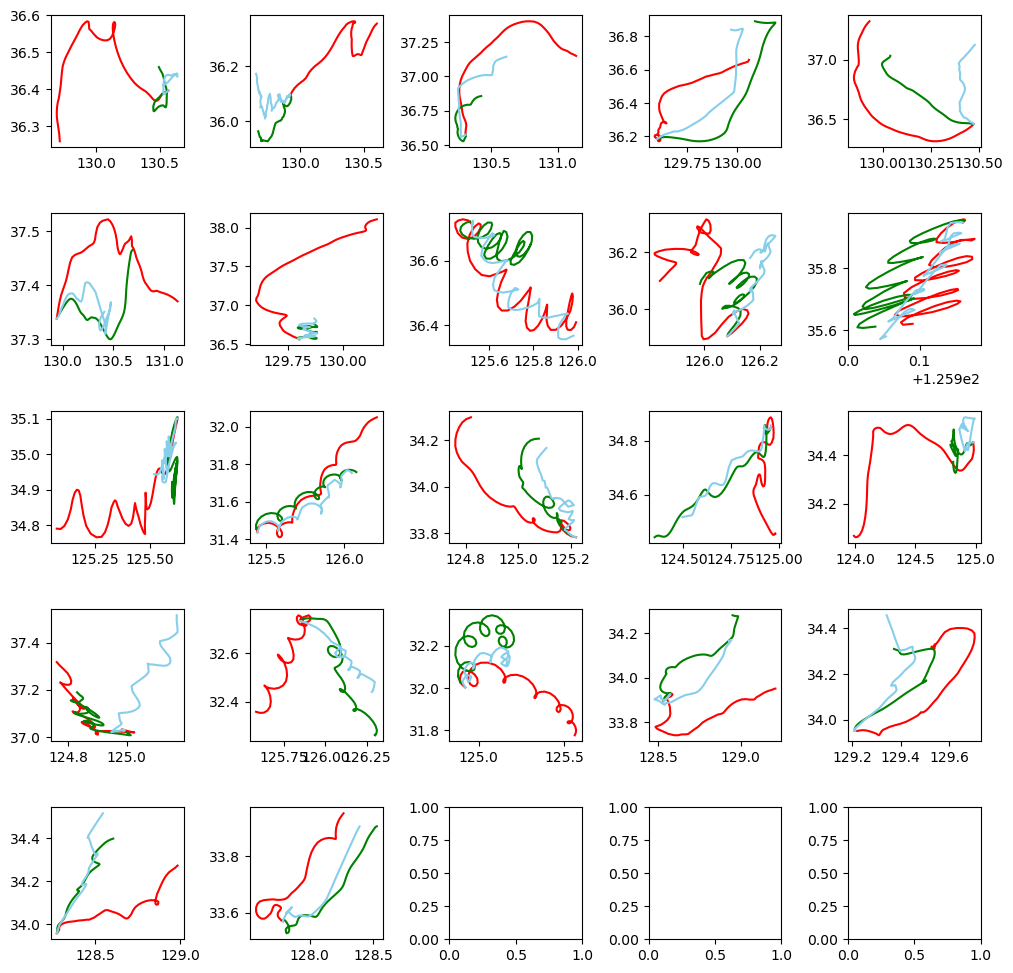

In [6]:
# RandomForest model (Feature 4개) & roburst
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 100, random_state = 12 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [7]:
# 특성 4개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]


# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17589311051628911
평균 NCLS :  0.5174574274657512


--------------------- Model  0  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

--------------------- Model  1  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

--------------------- Model  2  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  3  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  4  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  5  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

--------------------- Model  6  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  7  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  8  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  9  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

--------------------- Model  10  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

--------------------- Model  11  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

--------------------- Model  12  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  13  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  14  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCop

--------------------- Model  15  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  16  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  17  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  18  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  19  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

--------------------- Model  20  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

--------------------- Model  21  ----------------------


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1203670147.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

------------------------ Model  0 ------------------------
baseline 0  MAE :  0.2653899166456586
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.25286002128597684
------------------------ Model  1 ------------------------
baseline 1  MAE :  0.3674224479732918
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.014557417924578542
------------------------ Model  2 ------------------------
baseline 2  MAE :  0.2751275775078237
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.44232244130601506
------------------------ Model  3 ------------------------
baseline 3  MAE :  0.14906550386347417
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.2861342664276786
------------------------ Model  4 ------------------------
baseline 4  MAE :  0.22843291813712074
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.491905138

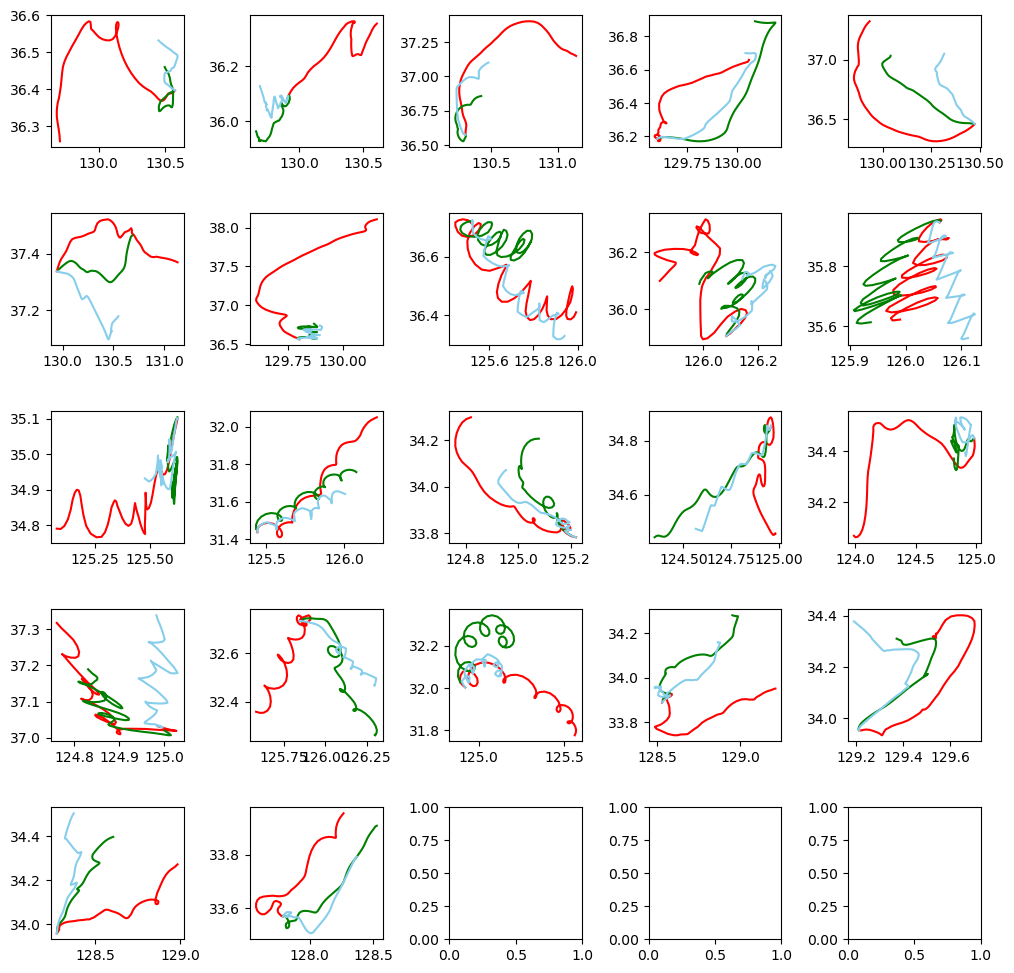

In [29]:
# RandomForest model (Feature 4개) & roburst & 과거 데이터 (훈련 데이터에 추가)
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()
test_case_list = list()

for i in range(len(dataset)):
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    test = dataset[i]
    start_lon = dataset[i]['start_lon'][0]
    start_lat = dataset[i]['start_lat'][0]
    
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    # 행단위로 살펴보기
    test_case_df = dataset[i][['time', 'obs_x1_lon', 'obs_x1_lat', 'wind_y','wind_x','water_velocity_y','water_velocity_x','model_x2_lon', 'model_x2_lat']]
    test_case_df['rf_lon'] = start_lon
    test_case_df['rf_lat'] = start_lat
    test_case_df['ncls_model'] = 0
    test_case_df['ncls_rf'] = 0
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 100 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # case 별로 이상행 탐색
    for k in range(1,len(test_case_df)-1):
        test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
        test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
        test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
        test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
    
    test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
    test_case_df['rf_diff_lon'][0] = 0
    test_case_df['rf_diff_lat'] = test_case_df['rf_lat'].diff()  
    test_case_df['rf_diff_lat'][0] = 0
    test_case_df['model_diff_lon'] = test_case_df['model_x2_lon'].diff() 
    test_case_df['model_diff_lon'][0] = 0
    test_case_df['model_diff_lat'] = test_case_df['model_x2_lat'].diff()
    test_case_df['model_diff_lat'][0] = 0
    
    test_case_list.append(test_case_df)
#     # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    baseline_pred = np.concatenate((baseline_lon.reshape((baseline_lon.shape[0],1)), baseline_lat.reshape((baseline_lat.shape[0],1))),axis =1)
    
    #mae
    MAE_list.append(drift_mae(y, pred))
    baseline_MAE_list.append(drift_mae(y, baseline_pred))
    
    
    #NCLS
    NCLS_list.append(NCLS_score(y, pred))
    baseline_NCLS_list.append(NCLS_score(y, baseline_pred))

for i in range(len(MAE_list)):
    print('------------------------ Model ', i, '------------------------')
    print('baseline',str(i),' MAE : ',MAE_list[i])
    print('Model',str(i),' MAE : ', baseline_MAE_list[i])
    print('baseline',str(i),' NCLS : ',baseline_NCLS_list[i])
    print('Model',str(i),' NCLS : ', NCLS_list[i])
    

plt.show()

In [22]:
# 특성 4개 & roburst & 과거데이터 추가
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]


# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17506384946860687
평균 NCLS :  0.525734898688644


In [30]:
test_case_list[5]

time  obs_x1_lon  obs_x1_lat    wind_y    wind_x  \
0  2016-02-12 15:00:00   129.94164    37.33764  8.686428  3.829966   
1  2016-02-12 16:00:00   129.95497    37.35394  7.952411  2.870588   
2  2016-02-12 17:00:00   129.97040    37.37006  7.666597  1.976911   
3  2016-02-12 18:00:00   129.98650    37.38218  7.629689  1.392242   
4  2016-02-12 19:00:00   130.00127    37.39033  7.631970  2.142313   
..                 ...         ...         ...       ...       ...   
67 2016-02-15 10:00:00   131.00049    37.38454 -3.870946  7.753403   
68 2016-02-15 11:00:00   131.03621    37.38204 -3.822586  8.063922   
69 2016-02-15 12:00:00   131.06995    37.37869 -4.127720  8.206757   
70 2016-02-15 13:00:00   131.10228    37.37473 -1.837945  7.447971   
71 2016-02-15 14:00:00   131.13346    37.36969 -1.901565  7.348385   

    water_velocity_y  water_velocity_x  model_x2_lon  model_x2_lat  \
0           0.003480          0.406080     129.96169     37.344300   
1          -0.018331          0.403051     129.98099     37.350990   
2          -0.044330          0.393772     129.99889     37.356600   
3          -0.074577          0.382194     130.01633     37.361620   
4          -0.073813          0.373700     130.03374     37.366467   
..               ...               ...           ...           ...   
67          0.174699          0.112541     130.66078     37.445568   
68          0.169211          0.115128     130.66553     37.450966   
69          0.161889          0.119003     130.67035     37.456170   
70          0.159763          0.116035     130.67499     37.461360   
71          0.160383          0.113148     130.68723     37.464806   

        rf_lon     rf_lat  ncls_model   ncls_rf  rf_diff_lon  rf_diff_lat  \
0   129.941640  37.337640    0.000000  0.000000          NaN          NaN   
1   129.955601  37.336599    0.000000  0.175906     0.013961    -0.001041   
2   129.967915  37.335940    0.104481  0.199676     0.012314    -0.000659   
3   129.982366  37.334616    0.265927  0.223871     0.014452    -0.001324   
4   129.995188  37.333757    0.355770  0.250248     0.012822    -0.000859   
..         ...        ...         ...       ...          ...          ...   
67  130.503566  37.169800    0.741053  0.474731     0.008983     0.003807   
68  130.512944  37.172379    0.739559  0.476411     0.009379     0.002579   
69  130.521783  37.176636    0.737665  0.477934     0.008839     0.004257   
70  130.530622  37.180893    0.735426  0.479319     0.008839     0.004257   
71  129.941640  37.337640    0.000000  0.000000    -0.588982     0.156747   

    model_diff_lon  model_diff_lat  
0              NaN             NaN  
1          0.01930        0.006690  
2          0.01790        0.005610  
3          0.01744        0.005020  
4          0.01741        0.004847  
..             ...             ...  
67         0.00464        0.005581  
68         0.00475        0.005398  
69         0.00482        0.005204  
70         0.00464        0.005190  
71         0.01224        0.003446  

[72 rows x 17 columns]

In [32]:
test_case_list[5].to_excel('C:\\Users\gusrl\\opendrift\\My_Drift_Model\\2016_case_016.xlsx', index = False, header=True)

In [24]:
case_list = ['2016_case_003','2016_case_005','2016_case_010','2016_case_011',
            '2016_case_015', '2016_case_016', '2016_case_040', '2018_case_005',
            '2018_case_017','2018_case_027','2018_case_032','2018_case_034',
            '2018_case_047','2018_case_082','2018_case_083','2018_case_090',
            '2018_case_095','2018_case_097','2019_case_000','2019_case_001',
            '2019_case_006','2019_case_005']
case_performance_df = pd.DataFrame()
case_performance_df['case'] = 0
case_performance_df['Baseline_MAE'] = 0
case_performance_df['Baseline_NCLS'] = 0
case_performance_df['My_MAE'] = 0
case_performance_df['My_NCLS'] = 0
case_performance_df['Better Mae'] = 0
case_performance_df['Better NCLS'] = 0

# print(case_list[i],' | ', baseline_MAE_list[i], ' | ', baseline_NCLS_list[i] ,' | ', MAE_list[i],' | ', NCLS_list[i] )
for i in range(len(case_list)):
    case_performance_df.loc[i] = [case_list[i],  baseline_MAE_list[i], baseline_NCLS_list[i], MAE_list[i], NCLS_list[i],0,0]
    if baseline_MAE_list[i] < MAE_list[i]: case_performance_df['Better Mae'][i] = 'baseline'
    else:  case_performance_df['Better Mae'][i] = 'My'
    
    if baseline_NCLS_list[i] < NCLS_list[i]: case_performance_df['Better NCLS'][i] = 'My'
    else:  case_performance_df['Better NCLS'][i] = 'Baseline'
    
case_performance_df.to_excel('C:\\Users\gusrl\\opendrift\\My_Drift_Model\\case_performance_df.xlsx', index = False, header=False)

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1416897393.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:  case_performance_df['Better Mae'][i] = 'My'
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1416897393.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:  case_performance_df['Better NCLS'][i] = 'Baseline'
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\1416897393.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [25]:
case_performance_df

case  Baseline_MAE  Baseline_NCLS    My_MAE   My_NCLS Better Mae  \
0   2016_case_003      0.277571       0.257834  0.270784  0.239989         My   
1   2016_case_005      0.410512       0.000000  0.364844  0.020193         My   
2   2016_case_010      0.352048       0.303684  0.277065  0.439269         My   
3   2016_case_011      0.239244       0.000000  0.149901  0.280750         My   
4   2016_case_015      0.143584       0.695637  0.228232  0.490808   baseline   
5   2016_case_016      0.110581       0.733055  0.210174  0.504812   baseline   
6   2016_case_040      0.420430       0.211407  0.431670  0.183370   baseline   
7   2018_case_005      0.118148       0.785579  0.037312  0.929959         My   
8   2018_case_017      0.103870       0.789964  0.140739  0.704602   baseline   
9   2018_case_027      0.038190       0.880436  0.033826  0.894920         My   
10  2018_case_032      0.141549       0.609692  0.126595  0.670125         My   
11  2018_case_034      0.079501       0.814597  0.111441  0.744162   baseline   
12  2018_case_047      0.071636       0.751613  0.072627  0.752753   baseline   
13  2018_case_082      0.135307       0.385714  0.094904  0.567838         My   
14  2018_case_083      0.222765       0.398567  0.248000  0.318692   baseline   
15  2018_case_090      0.030370       0.893674  0.085783  0.677649   baseline   
16  2018_case_095      0.209971       0.320573  0.198561  0.309540         My   
17  2018_case_097      0.247859       0.564514  0.183326  0.656266         My   
18  2019_case_000      0.145793       0.550310  0.120544  0.649940         My   
19  2019_case_001      0.080640       0.737077  0.107000  0.653408   baseline   
20  2019_case_006      0.171631       0.430087  0.230489  0.240897   baseline   
21  2019_case_005      0.131566       0.575641  0.127588  0.636225         My   

   Better NCLS  
0     Baseline  
1           My  
2           My  
3           My  
4     Baseline  
5     Baseline  
6     Baseline  
7           My  
8     Baseline  
9           My  
10          My  
11    Baseline  
12          My  
13          My  
14    Baseline  
15    Baseline  
16    Baseline  
17          My  
18          My  
19    Baseline  
20    Baseline  
21          My

--------------------- Model  0  ----------------------
Model 0  MAE :  0.2803057373009884
Model 0  NCLS :  0.33176695964416636
--------------------- Model  1  ----------------------
Model 1  MAE :  0.33926681417462967
Model 1  NCLS :  0.03093269628859352
--------------------- Model  2  ----------------------
Model 2  MAE :  0.26102292778580477
Model 2  NCLS :  0.46785045946313175
--------------------- Model  3  ----------------------
Model 3  MAE :  0.18889497084378437
Model 3  NCLS :  0.1568289466742423
--------------------- Model  4  ----------------------
Model 4  MAE :  0.2765877764784443
Model 4  NCLS :  0.3548926338566786
--------------------- Model  5  ----------------------
Model 5  MAE :  0.1596140657990446
Model 5  NCLS :  0.6084527368508472
--------------------- Model  6  ----------------------
Model 6  MAE :  0.40732811923026924
Model 6  NCLS :  0.23088844728452063
--------------------- Model  7  ----------------------
Model 7  MAE :  0.051848116785614136
Model 7  NCLS :  0

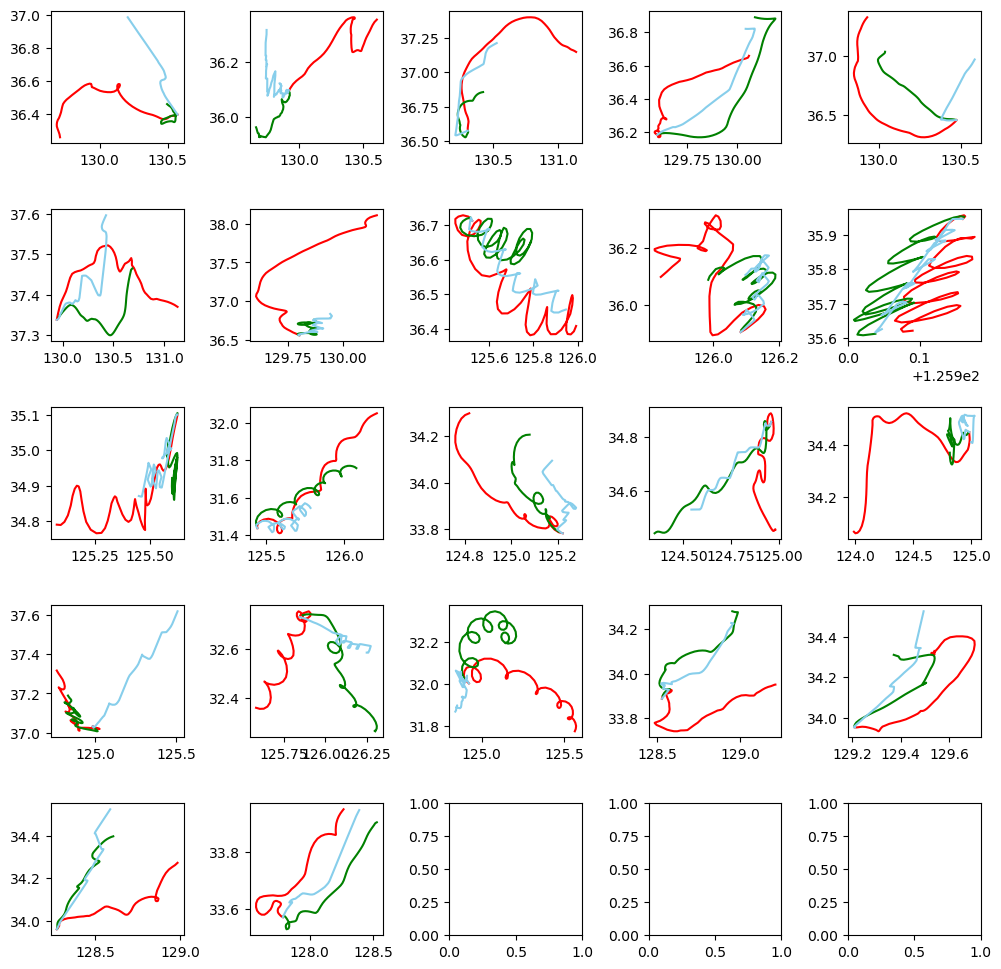

In [16]:
# RandomForest model (Feature 6개) & roburst 
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 4, n_estimators = 100, random_state = 12 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [17]:
# 특성 6개 & roburst 
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.18575536011183652
평균 NCLS :  0.4868865307645272


--------------------- Model  0  ----------------------
Model 0  MAE :  0.3081675143112615
Model 0  NCLS :  0.14876903301518185
--------------------- Model  1  ----------------------
Model 1  MAE :  0.23313219119058617
Model 1  NCLS :  0.35403582884116713
--------------------- Model  2  ----------------------
Model 2  MAE :  0.3138021827302693
Model 2  NCLS :  0.3713629322572096
--------------------- Model  3  ----------------------
Model 3  MAE :  0.19254599145588913
Model 3  NCLS :  0.14825411349703788
--------------------- Model  4  ----------------------
Model 4  MAE :  0.16200711371656895
Model 4  NCLS :  0.6502425542802728
--------------------- Model  5  ----------------------
Model 5  MAE :  0.1596409880509467
Model 5  NCLS :  0.6154237255701399
--------------------- Model  6  ----------------------
Model 6  MAE :  0.4414738660948653
Model 6  NCLS :  0.17604306173336148
--------------------- Model  7  ----------------------
Model 7  MAE :  0.03337680647061495
Model 7  NCLS :  0.9

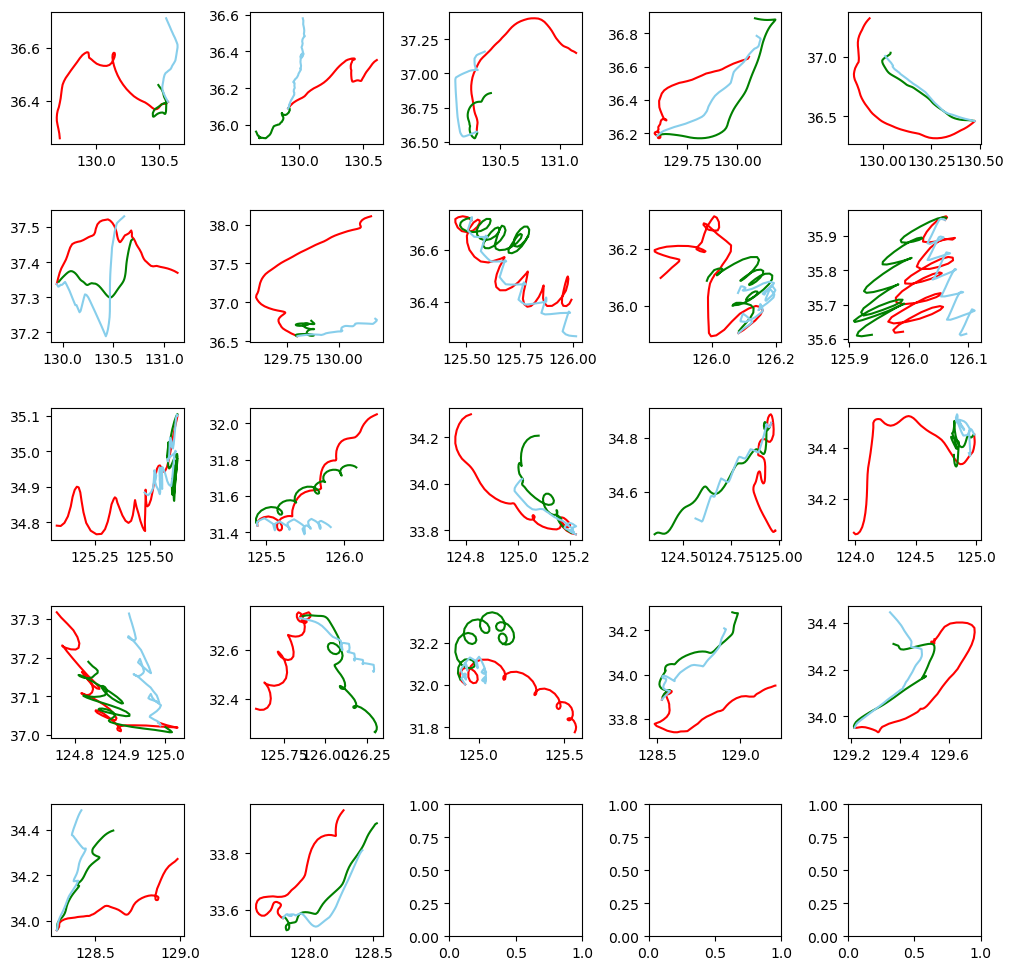

In [18]:
# RandomForest model (Feature 6개) & roburst & 과거데이터 추가
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 100 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [20]:
# 특성 6개 & roburst & 과거데이터 추가
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17325716731737487
평균 NCLS :  0.5307609284433802


--------------------- Model  0  ----------------------
Model 0  MAE :  0.28944244967830884
Model 0  NCLS :  0.17621443561562056
--------------------- Model  1  ----------------------
Model 1  MAE :  0.38086158404911574
Model 1  NCLS :  0
--------------------- Model  2  ----------------------
Model 2  MAE :  0.2544862342469412
Model 2  NCLS :  0.48111577253541404
--------------------- Model  3  ----------------------
Model 3  MAE :  0.19505048244639295
Model 3  NCLS :  0.12756551300674268
--------------------- Model  4  ----------------------
Model 4  MAE :  0.24648640371394326
Model 4  NCLS :  0.43837516691663425
--------------------- Model  5  ----------------------
Model 5  MAE :  0.15634073471817214
Model 5  NCLS :  0.6086119611768248
--------------------- Model  6  ----------------------
Model 6  MAE :  0.4112150941142867
Model 6  NCLS :  0.2287186524277406
--------------------- Model  7  ----------------------
Model 7  MAE :  0.03306886811028627
Model 7  NCLS :  0.9338097978142892

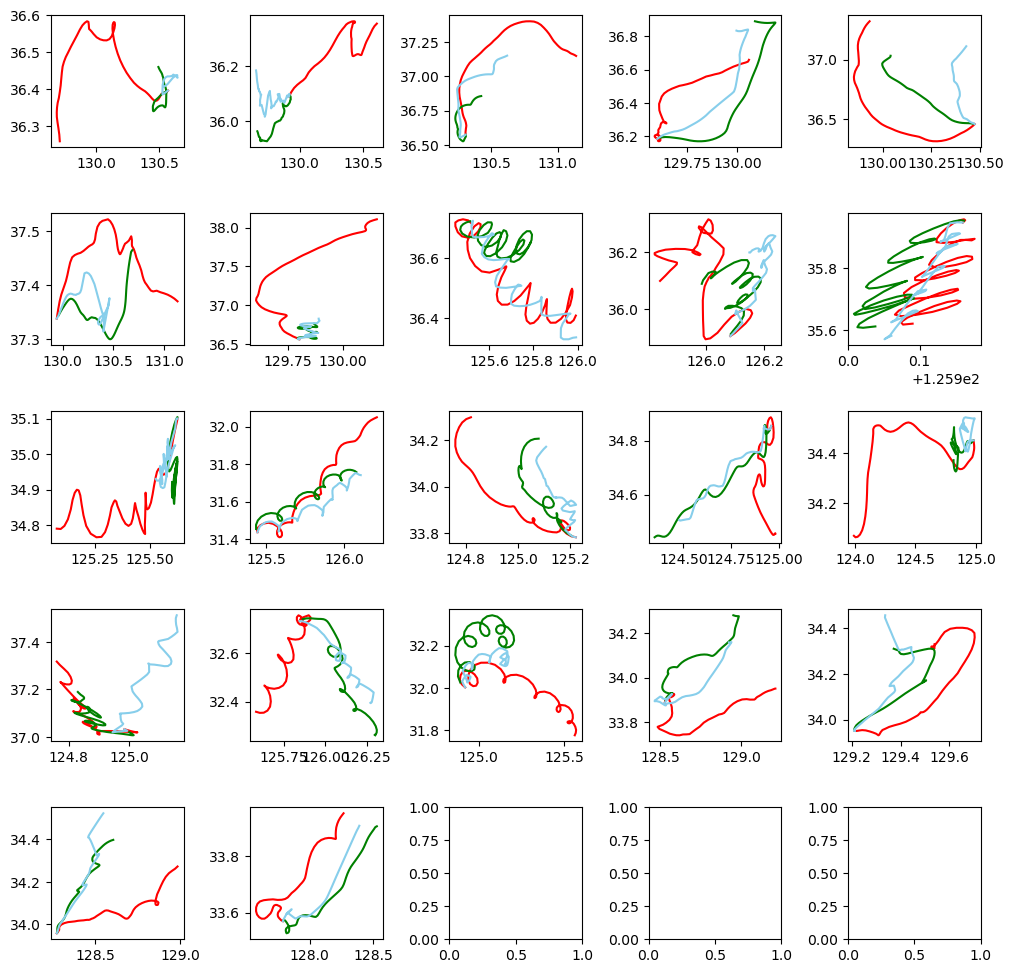

In [21]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = std_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 400, random_state = 12 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [23]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst
# 특성 6개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17441279200647367
평균 NCLS :  0.5193513433742062


--------------------- Model  0  ----------------------
Model 0  MAE :  0.2701165462285978
Model 0  NCLS :  0.238292888848198
--------------------- Model  1  ----------------------
Model 1  MAE :  0.3711056537640941
Model 1  NCLS :  0.002107661699580099
--------------------- Model  2  ----------------------
Model 2  MAE :  0.29027188806925885
Model 2  NCLS :  0.4176912078031556
--------------------- Model  3  ----------------------
Model 3  MAE :  0.15825597482822368
Model 3  NCLS :  0.23986764758137558
--------------------- Model  4  ----------------------
Model 4  MAE :  0.21763201004019506
Model 4  NCLS :  0.5199249954463744
--------------------- Model  5  ----------------------
Model 5  MAE :  0.20757107299306687
Model 5  NCLS :  0.5104802597676064
--------------------- Model  6  ----------------------
Model 6  MAE :  0.4308104876589551
Model 6  NCLS :  0.18497451751213623
--------------------- Model  7  ----------------------
Model 7  MAE :  0.0391624656334697
Model 7  NCLS :  0.92

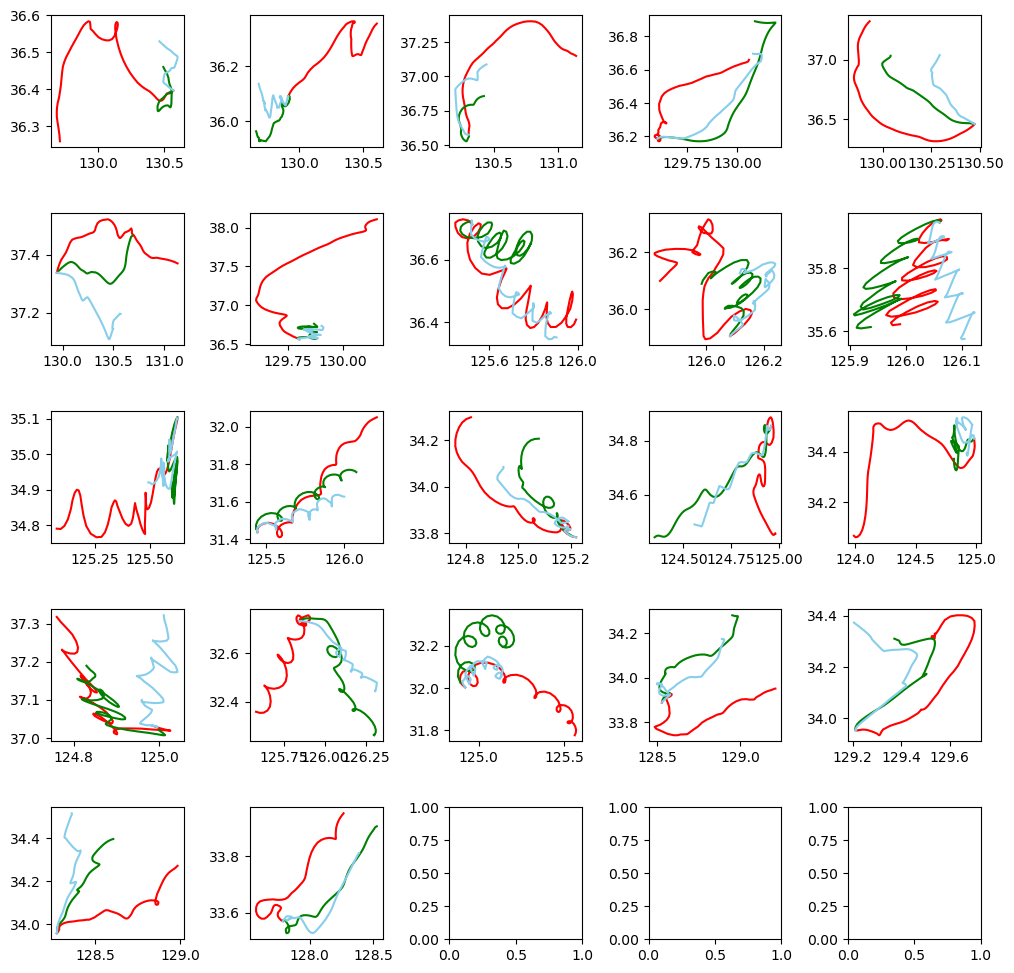

In [24]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst & 과거 데이터 훈련데이터에 추가
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = std_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 400, random_state = 12 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [25]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst & 이전데이터 추가
# 특성 6개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17662435480222474
평균 NCLS :  0.5194529607464324


--------------------- Model  0  ----------------------
Model 0  MAE :  0.30360827066830876
Model 0  NCLS :  0.13275115773865065
--------------------- Model  1  ----------------------
Model 1  MAE :  0.37313813530248974
Model 1  NCLS :  0
--------------------- Model  2  ----------------------
Model 2  MAE :  0.22960035759989347
Model 2  NCLS :  0.5268041763003801
--------------------- Model  3  ----------------------
Model 3  MAE :  0.21064076072165935
Model 3  NCLS :  0.05561660432225113
--------------------- Model  4  ----------------------
Model 4  MAE :  0.2533738740363227
Model 4  NCLS :  0.42967029990736927
--------------------- Model  5  ----------------------
Model 5  MAE :  0.169023770550154
Model 5  NCLS :  0.5851659279484939
--------------------- Model  6  ----------------------
Model 6  MAE :  0.41194929681692616
Model 6  NCLS :  0.22791258140776605
--------------------- Model  7  ----------------------
Model 7  MAE :  0.03977858907135426
Model 7  NCLS :  0.9224604012829882


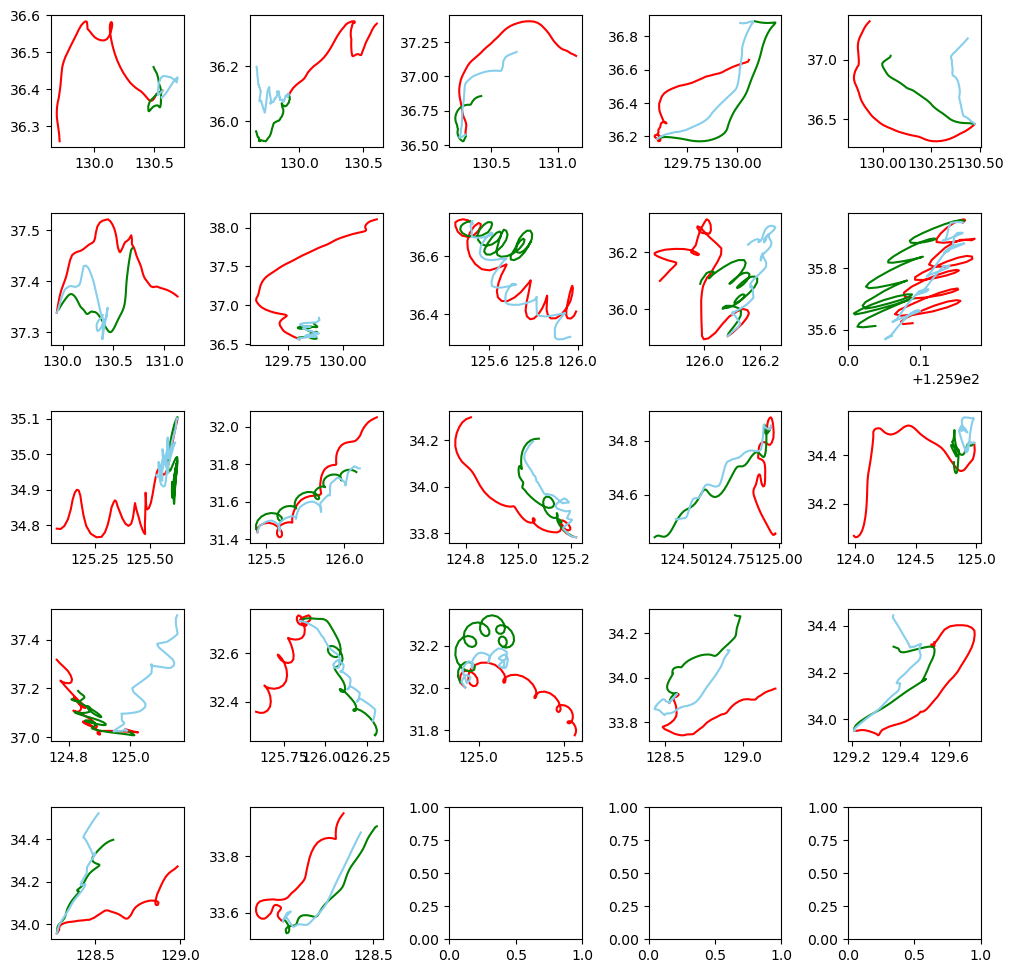

In [16]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst
# GridSearchCV 이용

from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()
grid_search_best = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','wind_x_ma','wind_y_ma','water_velocity_x_ma','water_velocity_y_ma']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()

    train_X, test_X = std_scaler(train_X, test_X)
    
    # Random Forest 모델 생성
    parameters = {
    'n_estimators': [100, 150, 200, 250, 300, 400],
    'max_depth': [ 6,7,8],
    }
    
    RD = RandomForestRegressor()
    grid_search = GridSearchCV(RD, parameters, scoring = 'neg_mean_squared_error')
    grid_search.fit(train_X, train_y)
    grid_search_best.append(grid_search.best_params_)
    RD.set_params(**grid_search.best_params_)
    RD.fit(train_X, train_y)
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [17]:
# RandomForest model Feature 8개(기본 Feature 4개 + smoothing 4개) & roburst
# 특성 6개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.17574472370504893
평균 NCLS :  0.5158247943778006


In [18]:
for i in range(22):
    print('------ model ',i+1, '의 beat parameter ------')
    print(grid_search_best[i])
    print(' ')

------ model  1 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 400}
 
------ model  2 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 300}
 
------ model  3 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 400}
 
------ model  4 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 200}
 
------ model  5 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 200}
 
------ model  6 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 100}
 
------ model  7 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 150}
 
------ model  8 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 250}
 
------ model  9 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 200}
 
------ model  10 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 300}
 
------ model  11 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 300}
 
------ model  12 의 beat parameter ------
{'max_depth': 6, 'n_estimators': 150}
 
------ model  13 의 beat parameter ---

In [32]:
!pip3 install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ------ --------------------------------- 41.0/250.0 kB ? eta -:--:--
     --------- ----------------------------- 61.4/250.0 kB 3.2 MB/s eta 0:00:01
     --------- ----------------------------- 61.4/250.0 kB 3.2 MB/s eta 0:00:01
     ------------- ----------------------- 92.2/250.0 kB 581.0 kB/s eta 0:00:01
     ------------- ----------------------- 92.2/250.0 kB 581.0 kB/s eta 0:00:01
     ------------- ----------------------- 92.2/250.0 kB 581.0 kB/s eta 0:00:01
     ------------- ----------------------- 92.2/250.0 kB 581.0 kB/s eta 0:00:01
     ---

In [33]:
import openpyxl
dataset[0].to_excel('inventors.xlsx', index=False)

In [35]:
# 엑셀로 변환 
# 태블로로 시각화하기
import openpyxl
for i in range(22):
    dataset[i].to_excel('case'+str(i+1)+'.xlsx', index=False)